<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Example-of-per-step-cost" data-toc-modified-id="Example-of-per-step-cost-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Example of per-step cost</a></span></li><li><span><a href="#Cost-vs-qubits-size" data-toc-modified-id="Cost-vs-qubits-size-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Cost vs qubits size</a></span></li><li><span><a href="#Cost-with-respect-to-depth" data-toc-modified-id="Cost-with-respect-to-depth-0.3"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>Cost with respect to depth</a></span></li></ul></li><li><span><a href="#Finding-biggest-tacklable-task" data-toc-modified-id="Finding-biggest-tacklable-task-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Finding biggest tacklable task</a></span><ul class="toc-item"><li><span><a href="#Full-ordering" data-toc-modified-id="Full-ordering-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Full ordering</a></span><ul class="toc-item"><li><span><a href="#Naive-(degree-based-local)-peo" data-toc-modified-id="Naive-(degree-based-local)-peo-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Naive (degree-based local) peo</a></span></li><li><span><a href="#QuickBB-peo" data-toc-modified-id="QuickBB-peo-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>QuickBB peo</a></span></li><li><span><a href="#Another-implementation-of-naive-peo" data-toc-modified-id="Another-implementation-of-naive-peo-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Another implementation of naive peo</a></span></li></ul></li></ul></li><li><span><a href="#Parallelize-after-critical-point" data-toc-modified-id="Parallelize-after-critical-point-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Parallelize after critical point</a></span><ul class="toc-item"><li><span><a href="#First-chopping" data-toc-modified-id="First-chopping-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>First chopping</a></span><ul class="toc-item"><li><span><a href="#Draw-chopped-graph" data-toc-modified-id="Draw-chopped-graph-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Draw chopped graph</a></span></li><li><span><a href="#Draw-chopped--parallelised-graph" data-toc-modified-id="Draw-chopped--parallelised-graph-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Draw chopped  parallelised graph</a></span></li><li><span><a href="#Late-paralelisaton-with-simple-reorder" data-toc-modified-id="Late-paralelisaton-with-simple-reorder-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Late paralelisaton with simple reorder</a></span><ul class="toc-item"><li><span><a href="#Full-chopped-cost" data-toc-modified-id="Full-chopped-cost-2.1.3.1"><span class="toc-item-num">2.1.3.1&nbsp;&nbsp;</span>Full chopped cost</a></span></li><li><span><a href="#Parallelised-chopped-cost" data-toc-modified-id="Parallelised-chopped-cost-2.1.3.2"><span class="toc-item-num">2.1.3.2&nbsp;&nbsp;</span>Parallelised chopped cost</a></span></li></ul></li><li><span><a href="#with-QuickBB-reorder" data-toc-modified-id="with-QuickBB-reorder-2.1.4"><span class="toc-item-num">2.1.4&nbsp;&nbsp;</span>with QuickBB reorder</a></span><ul class="toc-item"><li><span><a href="#Full-chopped-cost" data-toc-modified-id="Full-chopped-cost-2.1.4.1"><span class="toc-item-num">2.1.4.1&nbsp;&nbsp;</span>Full chopped cost</a></span></li><li><span><a href="#Parallelized-chopped-cost" data-toc-modified-id="Parallelized-chopped-cost-2.1.4.2"><span class="toc-item-num">2.1.4.2&nbsp;&nbsp;</span>Parallelized chopped cost</a></span></li></ul></li></ul></li><li><span><a href="#Second-chopping" data-toc-modified-id="Second-chopping-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Second chopping</a></span><ul class="toc-item"><li><span><a href="#Draw-chopped--parallelised-graph" data-toc-modified-id="Draw-chopped--parallelised-graph-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Draw chopped  parallelised graph</a></span></li><li><span><a href="#with-naive-reorder" data-toc-modified-id="with-naive-reorder-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>with naive reorder</a></span></li><li><span><a href="#with-QuickBB-reorder" data-toc-modified-id="with-QuickBB-reorder-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>with QuickBB reorder</a></span></li></ul></li></ul></li><li><span><a href="#Profiling-actual-simulation" data-toc-modified-id="Profiling-actual-simulation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Profiling actual simulation</a></span></li></ul></div>

In [2]:
import numpy as np
import networkx as nx
from loguru import logger as log
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import qtree 
import utils
import utils_qaoa as qaoa

%load_ext autoreload
%autoreload 2

ModuleNotFoundError("No module named 'tensorflow'")


In [3]:
def get_test_graph(S):
    #G = nx.triangular_lattice_graph(S, S)
    G = nx.grid_2d_graph(S+1, (2+S)//2)
    # remove grid labelling
    gen = (x for x in range(G.number_of_nodes()))
    G = nx.relabel_nodes(G, lambda x: next(gen))
    return G

def get_test_qaoa(S, p):
    G = get_test_graph(S)
    N = G.number_of_nodes()
    beta, gamma = [np.pi/3]*p, [np.pi/2]*p
    qc = qaoa.get_qaoa_circuit(G, beta, gamma)
    return qc, N

def get_test_expr_graph(S, p):
    qc, N = get_test_qaoa(S, p)
    graph = qtree.graph_model.circ2graph(N, qc)
    return graph, N

def get_optimized_expr(S, p):
    graph, N = get_test_expr_graph(S, p)
    graph_opt, nghs = _optimise_graph(graph)
    return graph_opt, nghs, N

def _optimise_graph(graph):
    peo, nghs = utils.get_locale_peo(graph, utils.n_neighbors)
    graph_opt, slice_dict = utils.reorder_graph(graph, peo)
    return graph_opt, nghs

def get_splitted_graph(S, p, pars):
    graph, N = get_test_expr_graph(S, p)
    idxs, graph = qtree.graph_model.split_graph_by_metric(graph, n_var_parallel=pars)
    graph_opt, nghs = _optimise_graph(graph)
    return graph, nghs, N

def get_cost_of_splitted(S, p, pars):
    graph, nghs, N = get_splitted_graph(S, p, pars)
    graph_opt, nghs = _optimise_graph(graph)
    mems, flops = qtree.graph_model.cost_estimator(graph_opt)
    return mems,flops,nghs, N

def get_cost_of_task(S, p=1):
    graph_opt, nghs, N = get_optimized_expr(S, p)
    mems, flops = qtree.graph_model.cost_estimator(graph_opt)
    return mems,flops,nghs, N

## Example of per-step cost

2020-03-08 00:36:44,729- INFO•	Generated graph with 976 nodes and 2136 edges


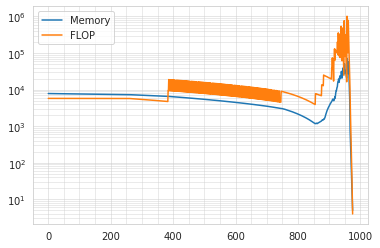

In [4]:
mems, flops, nghs, N = get_cost_of_task(15)
utils.plot_cost(mems, flops)

## Cost vs qubits size 

In [5]:
def log_log_scale():
    plt.yscale('log')
    plt.xscale('log')
    
def minorticks():
    plt.minorticks_on()
    plt.grid(which='minor', alpha=0.5, linestyle='-', axis='both')
    
def get_est(xs, vals):
    mem_est = np.polyfit(np.log(xs), np.log(vals), 2)
    mem_est = np.poly1d(mem_est)
    est = np.linspace(20,1e2, 100)
    est = np.log(est)
    mem_est = mem_est(est)
    return np.exp(est),  np.exp(mem_est)

In [ ]:
sizes = np.arange(5,17,1)
results = [
   get_cost_of_task(s, 3) for s in sizes
]
def plot_theory(results):
    sums = [[sum(x) for x in y[:3]] for y in results]
    memsums, flopsums, nghssums = zip(*sums)
    ns = list(zip(*results))[3]

    est, mem_est = get_est(ns, memsums)
    est, flop_est = get_est(ns, flopsums)


    plt.plot(ns, memsums, label='mem sum')
    plt.plot(ns, flopsums, label='flop sum')
    plt.plot(est, mem_est, '--', label='mem log-log fit')
    plt.plot(est, flop_est, '--', label='flop log-log fit')

    plt.xlabel('Number of qbits')
    plt.yscale('log')
    plt.xscale('log')
    plt.suptitle('QAOA one amplitude simulation cost', fontsize=14)
    plt.title('MaxCut triangular grids')
    plt.legend()
    plt.minorticks_on()
    plt.grid(which='minor', alpha=0.5, linestyle='-', axis='both')

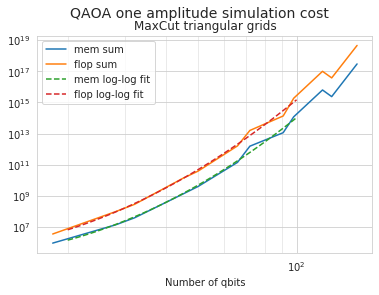

In [125]:
plot_theory(results)


## Cost with respect to depth


In [7]:
psize = 4
Ssize = 9

costs_with_p = []
for p in range(1, 1+psize):
    for S in range(2, 2+Ssize):
        costs = get_cost_of_task(S, p)
        costs_with_p.append(costs)

2020-03-07 16:18:07,835- INFO•	Generated graph with 38 nodes and 73 edges
2020-03-07 16:18:07,866- INFO•	Generated graph with 52 nodes and 102 edges
2020-03-07 16:18:07,936- INFO•	Generated graph with 104 nodes and 214 edges
2020-03-07 16:18:08,172- INFO•	Generated graph with 126 nodes and 261 edges
2020-03-07 16:18:08,396- INFO•	Generated graph with 202 nodes and 427 edges
2020-03-07 16:18:08,866- INFO•	Generated graph with 232 nodes and 492 edges
2020-03-07 16:18:09,428- INFO•	Generated graph with 332 nodes and 712 edges
2020-03-07 16:18:10,666- INFO•	Generated graph with 370 nodes and 795 edges
2020-03-07 16:18:12,280- INFO•	Generated graph with 494 nodes and 1069 edges
2020-03-07 16:18:15,233- INFO•	Generated graph with 64 nodes and 140 edges
2020-03-07 16:18:15,289- INFO•	Generated graph with 88 nodes and 196 edges
2020-03-07 16:18:15,505- INFO•	Generated graph with 178 nodes and 413 edges
2020-03-07 16:18:15,944- INFO•	Generated graph with 216 nodes and 504 edges
2020-03-07 16:18

(4, 4, 9)


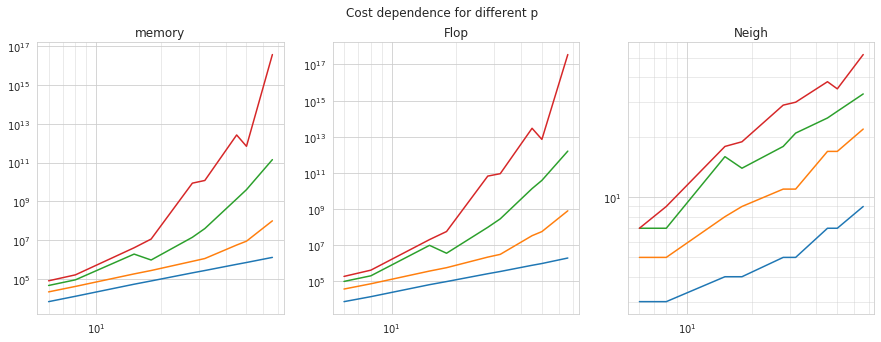

In [9]:

costs_with_p_p= [(sum(x[0]), sum(x[1]), max(x[2]), x[3]) for x in costs_with_p]
data = np.array(list(zip(*costs_with_p_p)))

data = data.reshape(4, psize, Ssize)
print(data.shape)

fig, axs = plt.subplots(1,3, figsize=(15, 5))

plt.sca(axs[0])
log_log_scale()
minorticks()
plt.title('memory')
for i in range(psize):
    plt.plot(data[-1,i], data[0,i])
    
plt.sca(axs[1])
log_log_scale()
minorticks()
plt.title('Flop')
for i in range(psize):
    plt.plot(data[-1,i], data[1,i])
    
plt.sca(axs[2])
log_log_scale()
minorticks()
plt.title('Neigh')
for i in range(psize):
    plt.plot(data[-1,i], data[2,i])

plt.suptitle('Cost dependence for different p')
plt.savefig('figures/cost_vs_p.png')

In [22]:
psize = 3
Ssize = 3
p = 1

costs_with_pars = []
for pars in range(1, 1+psize):
    for S in range(25, 25+Ssize):
        costs = get_cost_of_splitted(S, p, pars)
        costs_with_pars.append(costs)
       

2020-03-07 18:34:38,667- INFO•	Generated graph with 2626 nodes and 5811 edges
2020-03-07 18:34:38,883- INFO•	Removed indices by parallelization:
[705]
2020-03-07 18:34:38,884- INFO•	Removed 1 variables
2020-03-07 18:36:28,152- INFO•	Generated graph with 2942 nodes and 6517 edges
2020-03-07 18:36:28,286- INFO•	Removed indices by parallelization:
[787]
2020-03-07 18:36:28,287- INFO•	Removed 1 variables
2020-03-07 18:39:14,285- INFO•	Generated graph with 3052 nodes and 6762 edges
2020-03-07 18:39:14,512- INFO•	Removed indices by parallelization:
[815]
2020-03-07 18:39:14,512- INFO•	Removed 1 variables
2020-03-07 18:41:51,030- INFO•	Generated graph with 2626 nodes and 5811 edges
2020-03-07 18:41:51,133- INFO•	Removed indices by parallelization:
[705, 707]
2020-03-07 18:41:51,134- INFO•	Removed 2 variables
2020-03-07 18:44:09,287- INFO•	Generated graph with 2942 nodes and 6517 edges
2020-03-07 18:44:09,580- INFO•	Removed indices by parallelization:
[787, 789]
2020-03-07 18:44:09,581- INFO•	

(4, 3, 3)


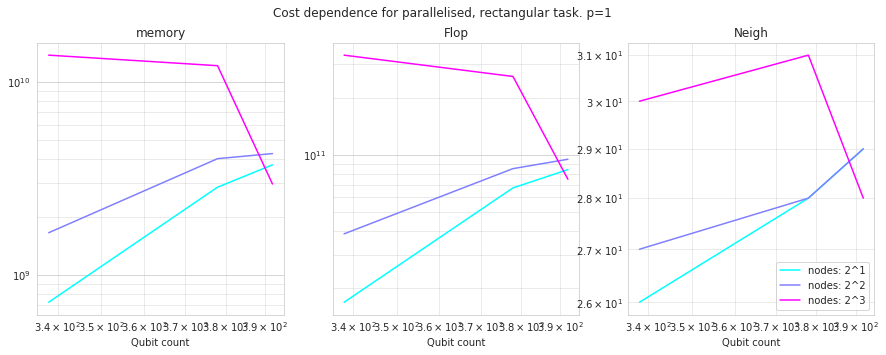

In [23]:


costs_with_p_ = [(sum(x[0]), sum(x[1]), max(x[2]), x[3]) for x in costs_with_pars]
data = np.array(list(zip(*costs_with_p_)))

data = data.reshape(4, psize, Ssize)
print(data.shape)

fig, axs = plt.subplots(1,3, figsize=(15, 5))
colormap = plt.cm.gist_ncar
labels = [f'nodes: 2^{i}' for i in range(1, 1+psize)]
for ax in axs:
    ax.set_prop_cycle(plt.cycler('color', plt.cm.cool(np.linspace(0, 1, psize))))
    ax.set_xlabel('Qubit count')

plt.sca(axs[0])
log_log_scale()
minorticks()
plt.title('memory')
for i in range(psize):
    plt.plot(data[-1,i], data[0,i])
    
plt.sca(axs[1])
log_log_scale()
minorticks()
plt.title('Flop')
for i in range(psize):
    plt.plot(data[-1,i], data[1,i])
    
plt.sca(axs[2])
log_log_scale()
minorticks()
plt.title('Neigh')
for i in range(psize):
    plt.plot(data[-1,i], data[2,i])
plt.legend(labels)

plt.suptitle('Cost dependence for parallelised, rectangular task. p=1')
plt.savefig('figures/rect_cost_vs_nodes_p1.png')

(4, 3, 3)


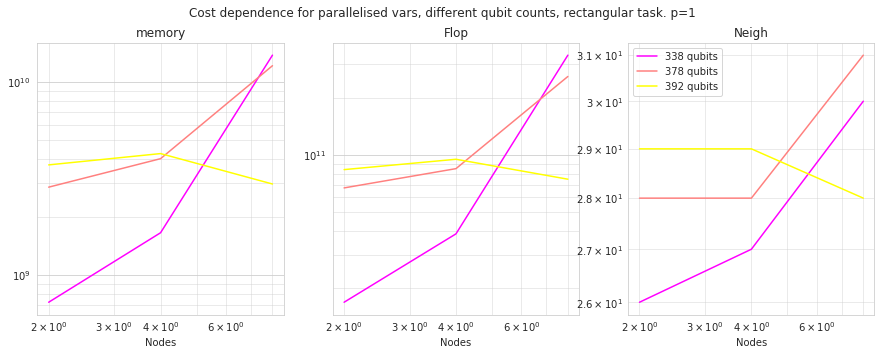

In [24]:

costs_with_p_ = [(sum(x[0]), sum(x[1]), max(x[2]), x[3]) for x in costs_with_pars]
data = np.array(list(zip(*costs_with_p_)))

data = data.reshape(4, psize, Ssize)
data = data.transpose(0,2,1)
print(data.shape)
processes = 2**(np.arange(1, 1+psize))
fig, axs = plt.subplots(1,3, figsize=(15, 5))
for ax in axs:
    ax.set_xlabel('Nodes')
    ax.set_prop_cycle(plt.cycler('color', plt.cm.spring(np.linspace(0, 1, psize))))

plt.sca(axs[0])
log_log_scale()
minorticks()
plt.title('memory')
for i in range(Ssize):
    plt.plot(processes, data[0,i])
    
plt.sca(axs[1])
log_log_scale()
minorticks()
plt.title('Flop')
for i in range(Ssize):
    plt.plot(processes, data[1,i])
    
plt.sca(axs[2])
log_log_scale()
minorticks()
plt.title('Neigh')
for i in range(Ssize):
    plt.plot(processes, data[2,i])

labels = [f'{int(i)} qubits' for i in data[-1,:, 0]]
plt.legend(labels)
plt.suptitle('Cost dependence for parallelised vars, different qubit counts, rectangular task. p=1')
plt.savefig('figures/rect_cost_vs_nodes_T_p1.png')
jjj

# Finding biggest tacklable task
## Full ordering

In [53]:
graph, N = get_test_expr_graph(40, 1)

print(N)

2020-03-08 01:31:10,535- INFO•	Generated graph with 6764 nodes and 15064 edges


861


### Naive (degree-based local) peo

61572.751818848
1935140.46488576
CPU times: user 9min 59s, sys: 277 ms, total: 9min 59s
Wall time: 10min 1s


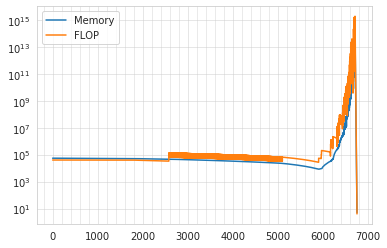

In [7]:
%%time
peo, nghs = utils.get_locale_peo(graph, utils.n_neighbors)
graph_relabel, slice_dict = utils.reorder_graph(graph, peo)

costs, flops = qtree.graph_model.cost_estimator(graph_relabel)
print(max(costs)/1e9)
print(max(flops)/1e9)
utils.plot_cost(costs, flops)

#nx.draw_kamada_kawai(graph, node_size=3)

### QuickBB peo

QuickBB usually fails on big (>5k nodes) graphs

In [18]:
%cd ..

/home/dali/anl/qsim/qtree


In [293]:
%%time
peoqbb, tw = qtree.graph_model.get_peo(graph)

2020-03-07 22:45:59,341- INFO•	generating config file output/quickbb.10139916.cnf
2020-03-07 22:45:59,351- INFO•	excecuting quickbb: ./quickbb/quickbb_64  --min-fill-ordering --time 60 --cnffile output/quickbb.10139916.cnf 


TypeError: 'NoneType' object is not subscriptable

In [294]:
graph, slice_dict = utils.reorder_graph(graph, peoqbb)

costs, mems = qtree.graph_model.cost_estimator(graph)
print(max(mems)/1e8)
print(max(costs)/1e8)
utils.plot_cost(costs, mems)
    

KeyError: 648

23.15255808


### Another implementation of naive peo

1351079888.2111487
43628621.39015268
CPU times: user 3min 23s, sys: 87.2 ms, total: 3min 24s
Wall time: 3min 25s


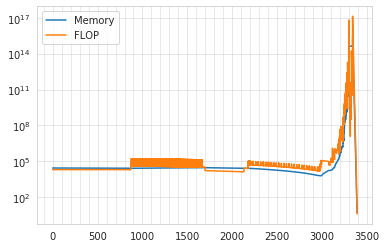

In [270]:
%%time
peon, nghs = utils.get_neighbours_peo(graph)
graph_relabel, slice_dict = utils.reorder_graph(graph, peon)

costs, mems = qtree.graph_model.cost_estimator(graph_relabel)
print(max(mems)/1e8)
print(max(costs)/1e8)
utils.plot_cost(costs, mems)

In [184]:
peo, nghs = utils.get_locale_peo(graph, utils.edges_to_clique)
graph_relabel, slice_dict = utils.reorder_graph(graph, peo)

costs, mems = qtree.graph_model.cost_estimator(graph_relabel)
utils.plot_cost(costs, mems)

/home/dali/anl/qsim/qtree/qtree/graph_model/graph_model.py:517: RuntimeWarning: overflow encountered in long_scalars
  flops = (size_of_the_result *
/home/dali/anl/qsim/qtree/qtree/graph_model/graph_model.py:507: RuntimeWarning: overflow encountered in long_scalars
  memory += mem


KeyboardInterrupt: 

# Parallelize after critical point

## First chopping 

In [54]:
chop1 = 5500

In [55]:
for n in peo[:chop1]:
    qtree.graph_model.eliminate_node(graph, n)
print('Nodes left:', graph.number_of_nodes())

Nodes left: 1264


### Draw chopped graph

In [12]:
print(peo[4100:])
print(sorted(graph.degree, key=lambda x: x[1]))
print(sorted([ utils.edges_to_clique(graph, x[0]) for x in graph.degree]))

[5489, 5488, 5409, 5493, 5492, 5413, 5497, 5496, 5417, 5501, 5500, 5421, 5505, 5504, 5425, 5509, 5508, 5429, 5513, 5512, 5433, 5517, 5516, 5437, 5521, 5520, 5441, 5525, 5524, 5445, 5529, 5528, 5449, 5533, 5532, 5535, 5534, 5455, 5539, 5538, 5459, 5543, 5542, 5463, 5547, 5546, 5467, 5551, 5550, 5471, 5555, 5554, 5475, 5559, 5558, 5479, 5563, 5562, 5483, 5567, 5566, 5487, 5571, 5570, 5491, 5575, 5574, 5495, 5579, 5578, 5499, 5583, 5582, 5503, 5587, 5586, 5507, 5591, 5590, 5511, 5595, 5594, 5515, 5599, 5598, 5519, 5603, 5602, 5523, 5607, 5606, 5527, 5611, 5610, 5531, 5615, 5614, 5617, 5616, 5537, 5621, 5620, 5541, 5625, 5624, 5545, 5629, 5628, 5549, 5633, 5632, 5553, 5637, 5636, 5557, 5641, 5640, 5561, 5645, 5644, 5565, 5649, 5648, 5569, 5653, 5652, 5573, 5657, 5656, 5577, 5661, 5660, 5581, 5665, 5664, 5585, 5669, 5668, 5589, 5673, 5672, 5593, 5677, 5676, 5597, 5681, 5680, 5601, 5685, 5684, 5605, 5689, 5688, 5609, 5693, 5692, 5613, 5697, 5696, 5699, 5698, 5619, 5703, 5702, 5623, 5707, 570

/usr/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


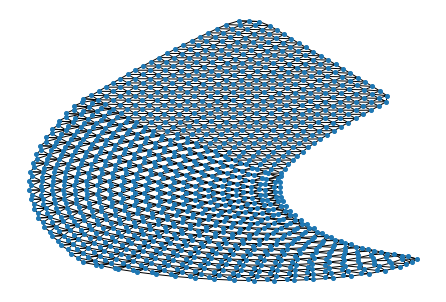

In [27]:
nx.draw_kamada_kawai(graph, node_size=16)

### Draw chopped  parallelised graph

2020-03-08 01:10:37,304- INFO•	Removed indices by parallelization:
[2543, 2545, 2547, 2549, 2551, 2553, 2555, 2557, 2559, 2565, 2567, 2569]
2020-03-08 01:10:37,306- INFO•	Removed 12 variables


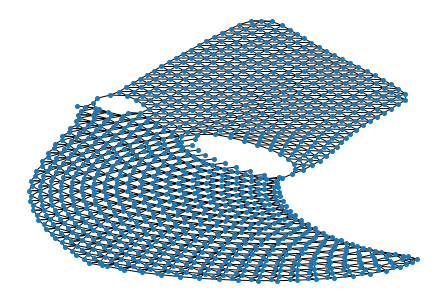

In [28]:
PAR_VARS = 12
par_vars, graph_split = qtree.graph_model.split_graph_by_metric(
    graph
    , n_var_parallel=PAR_VARS
)
nx.draw_kamada_kawai(graph_split, node_size=16)

### Late paralelisaton with simple reorder

#### Full chopped cost

61572.751818848
1935140.46488576


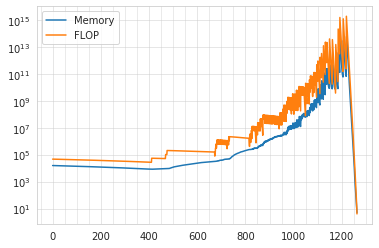

In [15]:
graph_opt, nghs = _optimise_graph(graph)
mems, flops = qtree.graph_model.cost_estimator(graph_opt)
print(max(mems)/1e9)
print(max(flops)/1e9)
utils.plot_cost(mems, flops)

#### Parallelised chopped cost

15393.565442142
474989.023199232


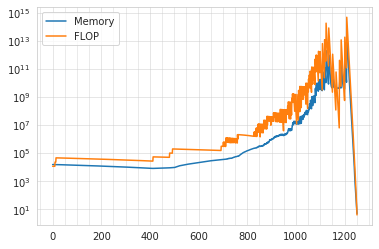

In [16]:
graph_split_opt, nghs = _optimise_graph(graph_split)
mems, flops = qtree.graph_model.cost_estimator(graph_split_opt)
print(max(mems)/1e9)
print(max(flops)/1e9)
utils.plot_cost(mems, flops)

### with QuickBB reorder

#### Full chopped cost

In [ ]:
peoqbb, tw = qtree.graph_model.get_peo(graph)
graph_opt_relabel, nghs = utils.reorder_graph(graph, peoqbb)
mems, flops = qtree.graph_model.cost_estimator(graph_opt_relabel)

15393.565442142
474989.023199232


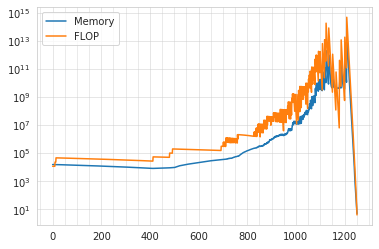

In [20]:
print(max(mems)/1e9)
print(max(flops)/1e9)
utils.plot_cost(mems, flops)

#### Parallelized chopped cost

In [29]:
peoqbb_split, tw = qtree.graph_model.get_peo(graph_split)

2020-03-08 01:11:08,236- INFO•	generating config file output/quickbb.80160975.cnf
2020-03-08 01:11:08,240- INFO•	excecuting quickbb: ./quickbb/quickbb_64  --min-fill-ordering --time 60 --cnffile output/quickbb.80160975.cnf 


TypeError: 'NoneType' object is not subscriptable

In [ ]:
graph_split_relabel, nghs = utils.reorder_graph(graph_split, peoqbb_split)
mems, flops = qtree.graph_model.cost_estimator(graph_split_relabel)
print(max(mems)/1e9)
print(max(flops)/1e9)
utils.plot_cost(mems, flops)

In [ ]:
peoqbb_split, tw = qtree.graph_model.get_peo(graph_split)

## Second chopping

In [56]:
chop2 = 900

In [57]:
for n in peo[chop1:chop1 + chop2]:
    qtree.graph_model.eliminate_node(graph, n)
print('Nodes left:', graph.number_of_nodes())

Nodes left: 364


In [58]:
print(peo[chop1 + chop2:])
print(sorted(graph.degree, key=lambda x: x[1]))
print(sorted([ utils.edges_to_clique(graph, x[0]) for x in graph.degree]))

[2383, 2407, 2409, 2463, 2503, 2543, 2471, 2511, 2551, 2485, 2487, 2539, 2579, 2619, 2613, 2655, 2631, 2671, 2749, 2879, 2881, 2883, 2887, 2889, 2953, 2955, 2957, 3041, 3043, 3045, 3115, 3117, 3119, 3137, 3139, 3207, 3209, 3281, 3283, 3285, 3287, 3297, 3299, 3301, 1789, 1791, 1829, 1833, 2557, 2599, 2639, 2679, 2907, 2949, 3091, 3131, 3107, 3143, 3145, 3147, 1933, 1935, 1937, 1979, 2021, 1943, 1983, 2023, 2063, 2105, 2719, 2721, 2723, 2373, 2375, 2377, 2053, 2095, 2137, 2221, 2263, 2305, 2347, 2737, 2779, 2819, 2861, 2807, 2809, 2851, 2891, 2933, 3071, 3113, 3155, 3197, 1757, 1797, 1837, 1875, 1877, 1915, 2399, 2441, 2483, 2523, 2565, 3205, 3247, 3289, 3291, 3333, 1781, 1821, 1861, 1903, 1945, 1987, 3057, 3099, 3141, 3183, 3223, 2027, 2029, 2031, 2067, 2107, 2147, 2189, 2085, 2087, 2089, 2197, 2239, 2281, 2499, 2541, 2583, 2959, 2999, 3039, 3217, 3219, 3221, 3263, 3303, 3343, 3383, 3423, 2387, 2389, 2427, 2431, 2467, 2473, 2667, 2709, 2711, 2753, 3051, 3093, 3135, 3175, 3215, 3255, 256

/usr/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


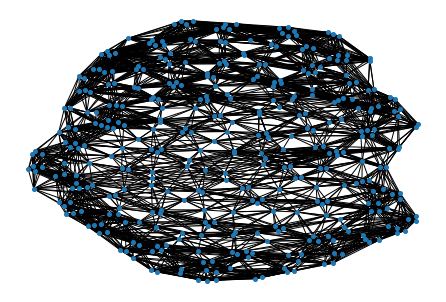

In [59]:
nx.draw_kamada_kawai(graph, node_size=16)

### Draw chopped  parallelised graph

2020-03-08 01:31:44,042- INFO•	Removed indices by parallelization:
[2083, 1925, 2051, 1869, 1875, 2323, 2371, 2649, 2975, 2363, 2703, 2787]
2020-03-08 01:31:44,043- INFO•	Removed 12 variables


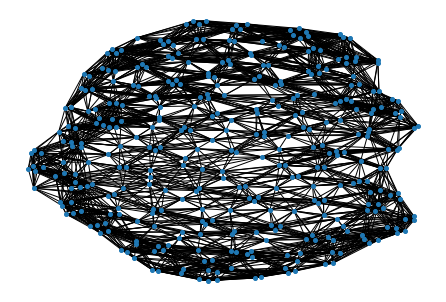

In [60]:
par_vars, graph_split = qtree.graph_model.split_graph_by_metric(graph, n_var_parallel=12)
nx.draw_kamada_kawai(graph_split, node_size=16)

### with naive reorder

61572.751818848
1935140.46488576


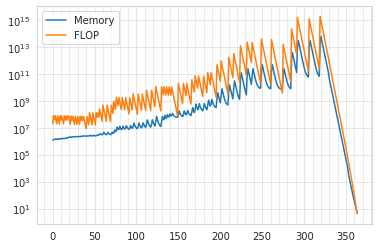

In [61]:
graph_opt, nghs = _optimise_graph(graph)
mems, flops = qtree.graph_model.cost_estimator(graph_opt)
print(max(mems)/1e9)
print(max(flops)/1e9)
utils.plot_cost(mems, flops)

30786.728230998
932385.860354048


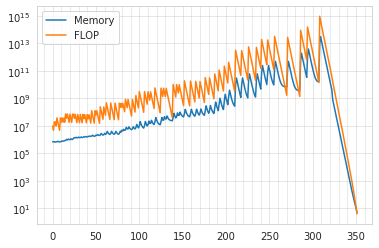

In [62]:
graph_split_opt, nghs = _optimise_graph(graph_split)
mems, flops = qtree.graph_model.cost_estimator(graph_split_opt)
print(max(mems)/1e9)
print(max(flops)/1e9)
utils.plot_cost(mems, flops)

### with QuickBB reorder

2020-03-08 01:32:13,382- INFO•	generating config file output/quickbb.59342320.cnf
2020-03-08 01:32:13,386- INFO•	excecuting quickbb: ./quickbb/quickbb_64  --min-fill-ordering --time 60 --cnffile output/quickbb.59342320.cnf 


3848.60841593
239693.534855168


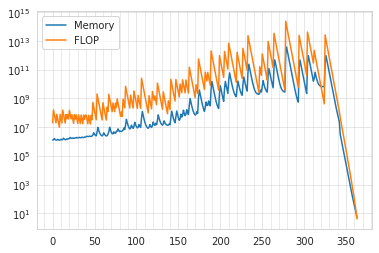

In [63]:
peoqbb, tw = qtree.graph_model.get_peo(graph)
graph_opt_relabel, nghs = utils.reorder_graph(graph, peoqbb)
mems, flops = qtree.graph_model.cost_estimator(graph_opt_relabel)
print(max(mems)/1e9)
print(max(flops)/1e9)
utils.plot_cost(mems, flops)

In [64]:
peoqbb_split, tw = qtree.graph_model.get_peo(graph_split)

2020-03-08 01:33:22,559- INFO•	generating config file output/quickbb.94711220.cnf
2020-03-08 01:33:22,563- INFO•	excecuting quickbb: ./quickbb/quickbb_64  --min-fill-ordering --time 60 --cnffile output/quickbb.94711220.cnf 


15406.047690836
457396.837154816


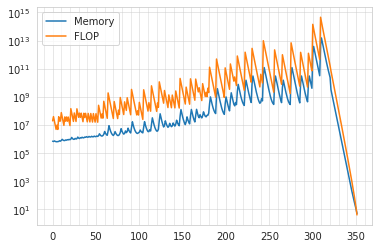

In [65]:
graph_split_relabel, nghs = utils.reorder_graph(graph_split, peoqbb_split)
mems, flops = qtree.graph_model.cost_estimator(graph_split_relabel)
print(max(mems)/1e9)
print(max(flops)/1e9)
utils.plot_cost(mems, flops)

114 78.0
[(1537, 1537), (1538, 1538), (1570, 1570), (1541, 1541), (1608, 1608), (1611, 1611), (1612, 1612), (1613, 1613), (1586, 1586), (1493, 1493), (1595, 1595), (1532, 1532), (1533, 1533)]
78
0


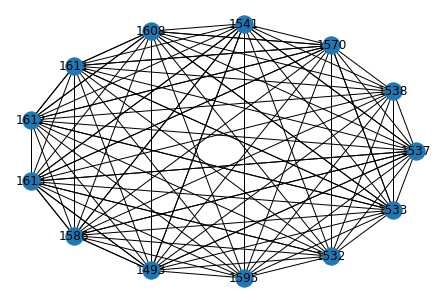

In [138]:
sg = graph.subgraph([1538] + list(graph.neighbors(1538)))
N = sg.number_of_nodes()
print(sg.number_of_edges(), 1/2*N*(N-1))
print(list(sg.selfloop_edges()))
edges = [e for e in graph.edges if all([e[-1]==0]+[x in sg.nodes for x in e[:2]])]
print(len(edges))
print(utils.edges_to_clique(graph, 1538))

nx.draw_shell(sg, with_labels=True)


# Profiling actual simulation


In [ ]:
from pyrofiler import mem_util, timed, timing
from pyrofiler.callbacks import append_to

In [ ]:
profile = {}

@mem_util(description='mem', callback=append_to(profile))
@timed('time', callback=append_to(profile))
@log.catch()
def simulate_circ(circuit, n_qubits):
    buckets, data_dict, bra_vars, ket_vars = qtree.optimizer.circ2buckets(
        n_qubits, circuit)

    graph = qtree.graph_model.buckets2graph(
        buckets,
        ignore_variables=bra_vars+ket_vars)

    peo, nghs = utils.get_locale_peo(graph, utils.n_neighbors)
    peo = qtree.graph_model.indices_to_vars(peo, graph)
    
    # place bra and ket variables to beginning, so these variables
    # will be contracted first
    #peo, treewidth = qtree.graph_model.get_peo(graph)

    peo = ket_vars + bra_vars + peo
    perm_buckets, perm_dict = qtree.optimizer.reorder_buckets(buckets, peo)

    # extract bra and ket variables from variable list and sort according
    # to qubit order
    ket_vars = sorted([perm_dict[idx] for idx in ket_vars], key=str)
    bra_vars = sorted([perm_dict[idx] for idx in bra_vars], key=str)

    # Take the subtensor corresponding to the initial state
    initial_state = target_state = 0
    slice_dict = qtree.utils.slice_from_bits(initial_state, ket_vars)
    slice_dict.update(
        qtree.utils.slice_from_bits(target_state, bra_vars)
    )
    sliced_buckets = qtree.np_framework.get_sliced_np_buckets(
        perm_buckets, data_dict, slice_dict)
    
    with timing('time_raw', callback=append_to(profile)):
        result = qtree.optimizer.bucket_elimination(
            sliced_buckets, qtree.np_framework.process_bucket_np)
        

In [ ]:
for key in profile:
    profile[key] = []
    
profile['N'] = []
sizes = np.arange(5,27) 

for S in sizes[:]:
    qc, N = get_test_qaoa(S)
    profile['N'].append(N)
    print(N,'qubits')
    result = simulate_circ(qc, N)

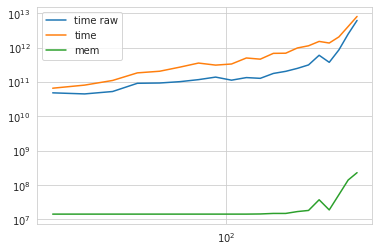

In [81]:
ns = profile['N']

def to_flop(secs):
    secs = np.array(secs)
    secs *= .3*1e12
    return secs
def to_nums(mems):
    mems = np.array(mems)
    mems = mems/16
    return mems

mems = to_nums(profile['mem'])
#mems -= np.min(mems)


plt.plot(ns, to_flop(profile['time_raw']), label='time raw')
plt.plot(ns, to_flop(profile['time']), label='time')
plt.plot(ns, mems, label='mem')
plt.legend()
plt.yscale('log')
plt.xscale('log')

In [ ]:
# Sizes for theory
sizes = np.arange(3,21)

In [ ]:
results = [
   get_cost_of_task(s) for s in sizes
]
sums = [[sum(x) for x in y[:3]] for y in results]
memsums, flopsums, nghssums = zip(*sums)
ns_theory = list(zip(*results))[3]

In [ ]:
est, mem_est = get_est(ns_theory, memsums)
est, flop_est = get_est(ns_theory, flopsums)

fig, axs = plt.subplots(1,2, figsize=(12,5))

plt.sca(axs[0])
log_log_scale()
minorticks()
plt.plot(ns_theory, memsums, label='theory')
plt.plot(ns, mems, label='experiment')
plt.plot(est, mem_est, '--', label='log-log fit')
plt.legend()
plt.title('Memory')
plt.xlabel('Number of qbits')

plt.sca(axs[1])
log_log_scale()
minorticks()
plt.plot(ns_theory, flopsums, label='theory')
plt.plot(ns, to_flop(profile['time']), label='experiment')
plt.plot(ns, to_flop(profile['time_raw']), label='experiment raw')
plt.plot(est, flop_est, '--', label='log-log fit')

plt.xlabel('Number of qbits')

plt.suptitle('QAOA one amplitude simulation cost', fontsize=14)
plt.title('FLOP')
plt.legend()


In [ ]:
filename = 'qaoa_cost_theory_exp'
plt.savefig(f'qaoa/figures/{filename}.png')
plt.savefig(f'qaoa/figures/{filename}.pdf')